In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, entropy, ttest_rel
import numpy as np
import sys
import warnings
from sklearn.metrics import classification_report, precision_recall_fscore_support
warnings.filterwarnings("ignore")
from pure_eval_supp import *

In [2]:
###
methods = ['stereoscope', 'spatialDWLS', 'RCTD','cell2loc', 'music', 'spotlight', 'BayesSpace']
cell_types = ['Cancer', 'Ductal', 'Stroma']
#folder = '/mnt/humble_50t/alexw/ReSort_manuscript/simulation/models_results/primary/infiltrated/'
#pure_gt_fn = '/mnt/humble_50t/alexw/ReSort_manuscript/simulation/simulated_data/primary/pure/simulated_spot_props_ground_truth.csv'
#infi_gt_fn = '/mnt/humble_50t/alexw/ReSort_manuscript/simulation/simulated_data/primary/infiltrated/simulated_spot_counts_ground_truth.csv'
folder = '../../models_results/primary/infiltrated/'
pure_gt_fn = '../../simulated_data/pure/simulated_spot_props_ground_truth_primary.csv'
infi_gt_fn = '../../simulated_data/infiltrated/simulated_spot_counts_ground_truth_primary.csv'
t0 = pd.read_csv(pure_gt_fn, index_col=0)
cancer_spots = t0.loc[(t0.Ductal == 0) & (t0.Stroma == 0)].index
truth = pd.read_csv(infi_gt_fn, index_col=0)
truth = truth[cell_types]
truth = truth.divide(truth.sum(axis=1), axis=0)
truth = truth.loc[cancer_spots]
truth.shape

(272, 3)

In [3]:
methods = ['stereoscope', 'spatialDWLS', 'RCTD','cell2loc', 'music', 'spotlight', 'BayesSpace']

r_dfs, kl_dfs = [], []

for method in methods:
    r_df, kl_df = get_results(method, cell_types, folder, truth)
    r_dfs.append(r_df)
    kl_dfs.append(kl_df)
r_dfs = pd.concat(r_dfs)
kl_dfs = pd.concat(kl_dfs)

In [4]:
# r_dfs.to_csv("Infiltrated_pearson_spots.csv")
# kl_dfs.to_csv("Infiltrated_kldivergene_spots.csv")

In [5]:
# writer = pd.ExcelWriter('SourceData-Figure2a-d.xlsx', engine='xlsxwriter')

# # Write each dataframe to a different worksheet.
# r_dfs.to_excel(writer, sheet_name='Fig2. a&b')
# kl_dfs.to_excel(writer, sheet_name='Fig2. c&d')

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()

In [6]:
internal_r = r_dfs.loc[r_dfs.reference == 'Internal']
external_r = r_dfs.loc[r_dfs.reference == 'External']
mist_r = r_dfs.loc[r_dfs.reference == 'ReSort']
internal_r.index = [f"{internal_r.index.tolist()[i]}_{internal_r.method.tolist()[i]}" for i in range(internal_r.shape[0])]
external_r.index = [f"{external_r.index.tolist()[i]}_{external_r.method.tolist()[i]}" for i in range(external_r.shape[0])]
mist_r.index = [f"{mist_r.index.tolist()[i]}_{mist_r.method.tolist()[i]}" for i in range(mist_r.shape[0])]
external_r = external_r.loc[internal_r.index]
mist_r = mist_r.loc[internal_r.index]
print(ttest_rel(internal_r.r.to_numpy(), mist_r.r.to_numpy(), nan_policy='omit'),
       np.nanmean(internal_r.r.to_numpy() - mist_r.r.to_numpy()),
      np.nanmean(np.absolute(internal_r.r.to_numpy() - mist_r.r.to_numpy())) / np.nanmean(internal_r.r.to_numpy()))

print(ttest_rel(external_r.r.to_numpy(), mist_r.r.to_numpy(), nan_policy='omit'),
      np.nanmean(external_r.r.to_numpy() - mist_r.r.to_numpy()),
      np.nanmean(np.absolute((external_r.r.to_numpy() - mist_r.r.to_numpy())) / np.nanmean(external_r.r.to_numpy())))

Ttest_relResult(statistic=-1.079124081073424, pvalue=0.2806919750605772) -0.00022261914440083533 0.001695747101078415
Ttest_relResult(statistic=-33.37184728065823, pvalue=1.4365089294301155e-186) -0.20024981883877047 0.25501583945070777


In [7]:
bs_r = r_dfs.loc[r_dfs.reference == 'BayesSpace']
mist_r_spots_idx = r_dfs.loc[r_dfs.reference == 'ReSort']
grps = mist_r_spots_idx.groupby('method')

for name, grp in grps:
    grp = grp.loc[bs_r.index,:]
    print(name, ttest_rel(bs_r.r.to_numpy(), grp.r.to_numpy(), nan_policy='omit'),
       np.nanmean(bs_r.r.to_numpy() - grp.r.to_numpy()),
      np.nanmean(np.absolute(bs_r.r.to_numpy() - grp.r.to_numpy())) / np.nanmean(grp.r.to_numpy()))

RCTD Ttest_relResult(statistic=-15.99535946982189, pvalue=5.233810886527152e-41) -0.719703782106919 0.7277835282903349
cell2loc Ttest_relResult(statistic=-16.095807572586835, pvalue=2.28292448218135e-41) -0.7221329125851749 0.7272544469898914
music Ttest_relResult(statistic=-16.039627108692066, pvalue=3.631003151920906e-41) -0.720080364473879 0.7272943604055891
spatialDWLS Ttest_relResult(statistic=-16.087173745507076, pvalue=2.451682636604929e-41) -0.721581100410822 0.7259313483547529
spotlight Ttest_relResult(statistic=-16.064877068609963, pvalue=2.947470036284093e-41) -0.7198660992955412 0.7285968400611261
stereoscope Ttest_relResult(statistic=-15.974627318551915, pvalue=6.211303005991143e-41) -0.7191893127261464 0.7283542755300094


In [8]:
internal_kl = kl_dfs.loc[kl_dfs.reference == 'Internal']
external_kl = kl_dfs.loc[kl_dfs.reference == 'External']
mist_kl = kl_dfs.loc[kl_dfs.reference == 'ReSort']

internal_kl.index = [f"{internal_kl.index.tolist()[i]}_{internal_kl.method.tolist()[i]}" for i in range(internal_kl.shape[0])]
external_kl.index = [f"{external_kl.index.tolist()[i]}_{external_kl.method.tolist()[i]}" for i in range(external_kl.shape[0])]
mist_kl.index = [f"{mist_kl.index.tolist()[i]}_{mist_kl.method.tolist()[i]}" for i in range(mist_kl.shape[0])]
external_kl = external_kl.loc[internal_kl.index]
mist_kl = mist_kl.loc[internal_kl.index]

print(ttest_rel(internal_kl.KL.to_numpy(), mist_kl.KL.to_numpy(), nan_policy='omit'),
      np.nanmean(np.absolute((internal_kl.KL.to_numpy() - mist_kl.KL.to_numpy()))) / np.nanmean(internal_kl.KL.to_numpy()))

print(ttest_rel(external_kl.KL.to_numpy(), mist_kl.KL.to_numpy(), nan_policy='omit'),
       np.nanmean(external_kl.KL.to_numpy() - mist_kl.KL.to_numpy()),
      np.nanmean(np.absolute((external_kl.KL.to_numpy() - mist_kl.KL.to_numpy())))/ np.nanmean(external_kl.KL.to_numpy()))

Ttest_relResult(statistic=22.426590110546623, pvalue=2.598679772606912e-97) 0.18915876808023865
Ttest_relResult(statistic=81.25888853085935, pvalue=0.0) 1.6169596268667106 0.8780400276691327


In [9]:
bs_kl = kl_dfs.loc[kl_dfs.reference == 'BayesSpace']
mist_kl_spots_idx = kl_dfs.loc[kl_dfs.reference == 'ReSort']
grps = mist_kl_spots_idx.groupby('method')

for name, grp in grps:
    grp = grp.loc[bs_kl.index,:]
    print(name, ttest_rel(bs_kl.KL.to_numpy(), grp.KL.to_numpy(), nan_policy='omit'),
       np.nanmean(bs_kl.KL.to_numpy() - grp.KL.to_numpy()),
      np.nanmean(np.absolute(bs_kl.KL.to_numpy() - grp.KL.to_numpy())) / np.nanmean(grp.KL.to_numpy()))

RCTD Ttest_relResult(statistic=15.46564792823402, pvalue=4.1481866459056386e-39) 3.136765381754689 318.03150171391064
cell2loc Ttest_relResult(statistic=15.458330317769883, pvalue=4.406286662934984e-39) 3.1344399981452016 257.4904296726247
music Ttest_relResult(statistic=14.50166540377247, pvalue=1.1561523720432383e-35) 2.9415406137015423 15.274951138266088
spatialDWLS Ttest_relResult(statistic=15.490747752724406, pvalue=3.3723769766719134e-39) 3.142192282426997 705.9009142879994
spotlight Ttest_relResult(statistic=10.20040071843517, pvalue=6.886113313992617e-21) 2.0457945579034806 2.8232867942648685
stereoscope Ttest_relResult(statistic=15.436595769647187, pvalue=5.2714504233629814e-39) 3.1307329329133875 197.42293164577086


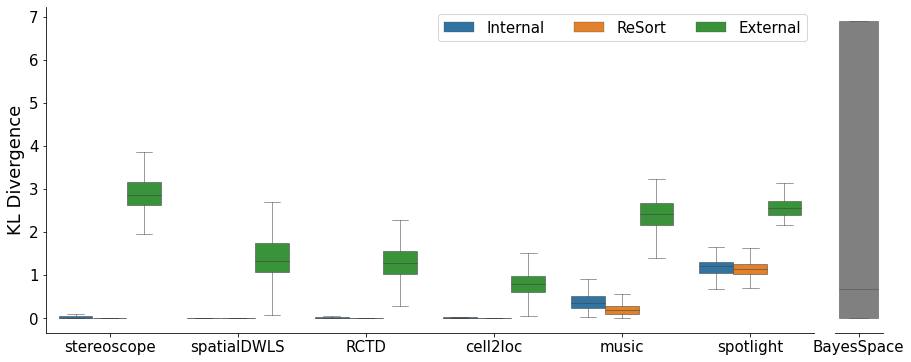

In [10]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6), gridspec_kw={'width_ratios': [16, 1]}, sharey=True)
sns.boxplot(data=kl_dfs.loc[kl_dfs.method!='BayesSpace'], x='method', y='KL', hue='reference', 
            hue_order = ['Internal', 'ReSort', 'External'], order = methods[:-1], ax=ax1, linewidth=0.5, showfliers = False)
sns.boxplot(data=kl_dfs.loc[kl_dfs.method=='BayesSpace'], x='method', y='KL', ax=ax2, linewidth=0.5, color='gray', showfliers = False)
sns.despine();

# plt.xticks(range(6), ['Stereoscope', 'spatialDWLS', 'RCTD', 'cell2loc', 'MuSiC', 'SPOTlight', 'BayesSpace'],
#           fontsize=15);
ax1.set_xlabel("")
ax1.tick_params(axis='both', labelsize=15)
ax1.set_ylabel("KL Divergence", fontsize=18)
ax1.legend(fontsize=15, ncol = 3);

ax2.set_xlabel("")
ax2.tick_params(axis='both', labelsize=15)
ax2.set_ylabel("")
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_ticks_position('none')
plt.subplots_adjust(wspace=0.05)
#plt.savefig('Fig2-Infiltrated_KL_diver_boxplot.png', dpi=200, bbox_inches='tight')

### Quantitatively assess

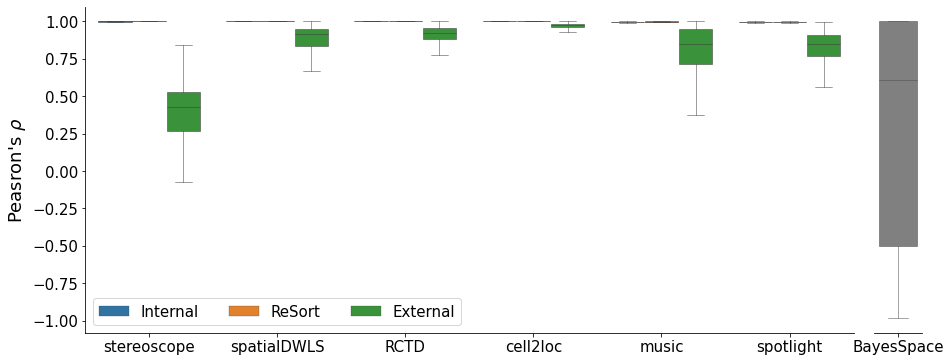

In [11]:
f, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 6), gridspec_kw={'width_ratios': [16, 1]}, sharey=True)

sns.boxplot(data=r_dfs.loc[r_dfs.method!='BayesSpace'], x='method', y='r', hue='reference', 
            hue_order = ['Internal', 'ReSort', 'External'], order = methods[:-1], ax=ax1, linewidth=0.5, showfliers = False);
sns.boxplot(data=r_dfs.loc[r_dfs.method=='BayesSpace'], x='method', y='r', ax=ax2, linewidth=0.5, color='gray', showfliers = False);
sns.despine();

# plt.xticks(range(6), ['Stereoscope', 'spatialDWLS', 'RCTD', 'cell2loc', 'MuSiC', 'SPOTlight'],
#           fontsize=15);

ax1.set_xlabel("")
ax1.tick_params(axis='both', labelsize=15)
ax1.set_ylabel(r"Peasron's $\rho$", fontsize=18)
ax1.legend(fontsize=15,  ncol = 3);

ax2.set_xlabel("")
ax2.tick_params(axis='both', labelsize=15)
ax2.set_ylabel("")
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_ticks_position('none')
plt.subplots_adjust(wspace=0.05)

plt.savefig('Fig2-Infiltrated_Pearson_boxplot.png', dpi=200, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


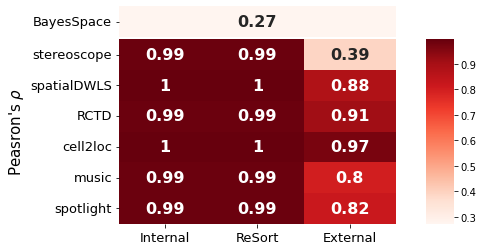

In [12]:
r_mean_df = pd.pivot_table(data=r_dfs, index='method', columns='reference', values='r', aggfunc='mean')
r_mean_df.index.name=None
r_mean_df.columns.name=None

vmin = np.nanmin(r_mean_df)
vmax = np.nanmax(r_mean_df)

f, axs = plt.subplots(2,2, gridspec_kw={'height_ratios': [1, 6], 'width_ratios': [10, 1]})

sns.heatmap(data=r_mean_df.loc[['BayesSpace'], ['BayesSpace']].round(2), annot=True,
            annot_kws={'weight':'bold', 'size':'16'}, 
            cmap='Reds', ax=axs[0,0], cbar=False, vmin=vmin, vmax=vmax)

axs[0,0].legend().remove()
axs[0,0].set_xticks([])
axs[0,0].set_xlabel('')
axs[0,0].tick_params(axis='y', labelsize=13, labelrotation=0)
axs[0,1].axis("off")

r_mean_df = r_mean_df.loc[methods[:-1], ['Internal','ReSort', 'External']]
sns.heatmap(data=r_mean_df.round(2), annot=True, annot_kws={'weight':'bold', 'size':'16'}, 
            cmap='Reds', ax=axs[1,0], cbar_ax = axs[1,1], vmin=vmin, vmax=vmax)

# ax.set_yticklabels(['Stereoscope', 'spatialDWLS', 'RCTD', 'cell2loc', 'MuSiC', 'SPOTlight']);
axs[1,0].set_xticklabels(['Internal', 'ReSort', 'External']);
axs[1,0].set_xlabel("")
axs[1,0].tick_params(axis='both', labelsize=13)
axs[1,0].set_ylabel(r"Peasron's $\rho$", fontsize=15)
plt.subplots_adjust(hspace=0.02)
plt.savefig('Fig2-Infiltrated_Mean_Pearson_r_heatmap.png', dpi=200, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


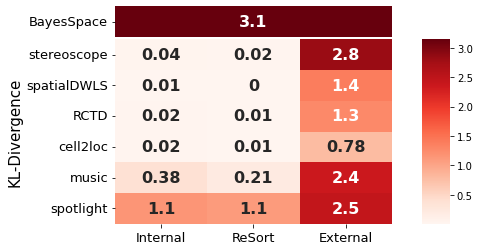

In [13]:
kl_mean_df = pd.pivot_table(data=kl_dfs, index='method', columns='reference', values='KL', aggfunc='mean')
kl_mean_df.index.name=None
kl_mean_df.columns.name=None

vmin = np.nanmin(kl_mean_df)
vmax = np.nanmax(kl_mean_df)

f, axs = plt.subplots(2,2, gridspec_kw={'height_ratios': [1, 6], 'width_ratios': [10, 1]})

sns.heatmap(data=kl_mean_df.loc[['BayesSpace'], ['BayesSpace']].round(2), annot=True,
            annot_kws={'weight':'bold', 'size':'16'}, 
            cmap='Reds', ax=axs[0,0], cbar=False, vmin=vmin, vmax=vmax)

axs[0,0].legend().remove()
axs[0,0].set_xticks([])
axs[0,0].set_xlabel('')
axs[0,0].tick_params(axis='y', labelsize=13, labelrotation=0)
axs[0,1].axis("off")

kl_mean_df = kl_mean_df.loc[methods[:-1], ['Internal','ReSort', 'External']]
sns.heatmap(data=kl_mean_df.round(2), annot=True, annot_kws={'weight':'bold', 'size':'16'}, 
            cmap='Reds', ax=axs[1,0], cbar_ax = axs[1,1], vmin=vmin, vmax=vmax)

# ax.set_yticklabels(['Stereoscope', 'spatialDWLS', 'RCTD', 'cell2loc', 'MuSiC', 'SPOTlight']);
axs[1,0].set_xticklabels(['Internal', 'ReSort', 'External']);
axs[1,0].set_xlabel("")
axs[1,0].tick_params(axis='both', labelsize=13)
axs[1,0].set_ylabel("KL-Divergence", fontsize=15)
plt.subplots_adjust(hspace=0.02)
plt.savefig('Fig2-Pure_Infiltrated_KL_heatmap.png', dpi=200, bbox_inches='tight')

#plt.savefig('Infiltrated_Mean_KL_diver_heatmap.png', dpi=200, bbox_inches='tight')

In [14]:
def customize_precision_recall_fscore(true, pred, thre=0.05):
    """2 class precision recall and f score calculation"""
    
    cancer_weight = np.sum(np.ravel(truth.Cancer >= (1 - 0.05))) / truth.shape[0]
    infil_weight = 1 - cancer_weight
    
    ## Cancer
    cancer_labels = (truth.Cancer >= 1- thre).astype(int)
    cancer_preds = (pred.Cancer >= 1-thre).astype(int)
    cancer_pre, cancer_rec, cancer_f1, _  = precision_recall_fscore_support(cancer_labels, cancer_preds, pos_label=1, average='binary')
    
    ## Stroma infiltration
    stroma_labels = (truth.Stroma > thre).astype(int)
    stroma_preds = (pred.Stroma > thre).astype(int)
    stroma_pre, stroma_rec, stroma_f1, _ =  precision_recall_fscore_support(stroma_labels, stroma_preds, pos_label=1, average='binary')
    
    ## average f1
    ave_f1 = cancer_weight * cancer_f1  + infil_weight * stroma_f1
    
    ## report
    df = pd.DataFrame(data=[[cancer_pre, cancer_rec, cancer_f1, stroma_pre, stroma_rec, stroma_f1, ave_f1]],
                      columns = ['Precision Cancer', 'Recall Cancer', 'F1 Cancer', 'Precision Stroma', 'Recall Stroma', 'F1 Stroma', 'F1 Weighted'])
    
    return df    

stereoscope
spatialDWLS
RCTD
cell2loc
music
spotlight


,Precision Cancer,Recall Cancer,F1 Cancer,Precision Stroma,Recall Stroma,F1 Stroma,F1 Weighted,reference,method
0,0.000000,0.000000,0.000000,0.095588,1.000000,0.174497,0.016680,External,spotlight
0,0.000000,0.000000,0.000000,0.095588,1.000000,0.174497,0.016680,Internal,spotlight
0,0.000000,0.000000,0.000000,0.095588,1.000000,0.174497,0.016680,ReSort,spotlight
0,0.000000,0.000000,0.000000,0.095941,1.000000,0.175084,0.016736,External,music
0,0.000000,0.000000,0.000000,0.961538,0.961538,0.961538,0.091912,External,stereoscope
0,0.000000,0.000000,0.000000,1.000000,0.961538,0.980392,0.093714,External,RCTD
0,0.000000,0.000000,0.000000,1.000000,0.961538,0.980392,0.093714,External,cell2loc
0,1.000000,0.052846,0.100386,0.337838,0.961538,0.500000,0.138584,Internal,music
0,1.000000,0.028455,0.055336,1.000000,1.000000,1.000000,0.145635,External,spatialDWLS
0,1.000000,0.369919,0.540059,0.510204,0.961538,0.666667,0.552162,ReSort,music


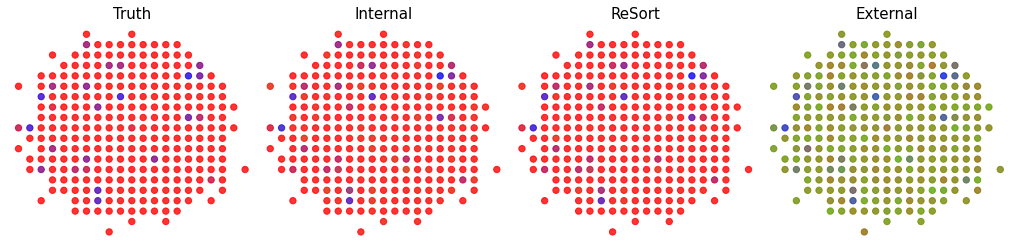

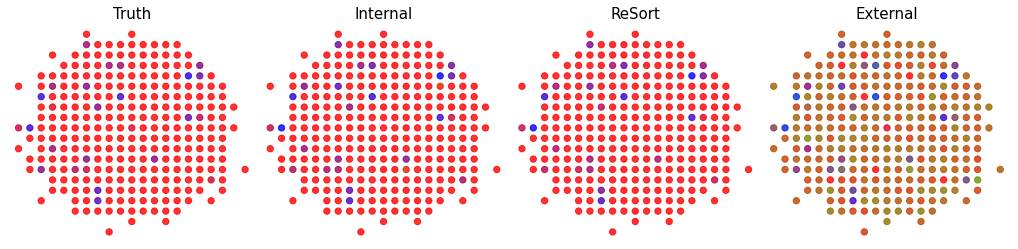

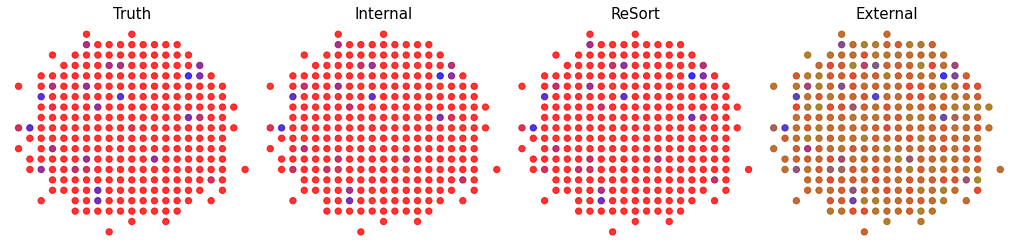

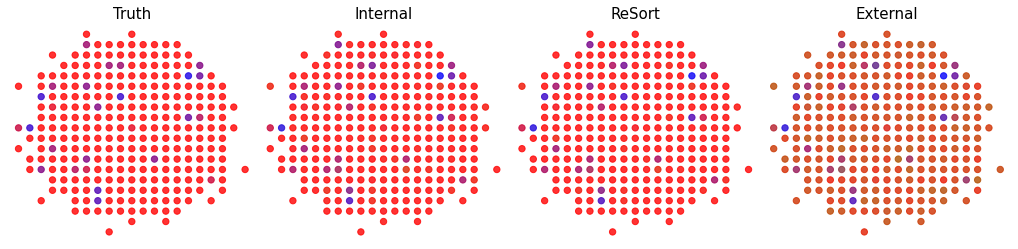

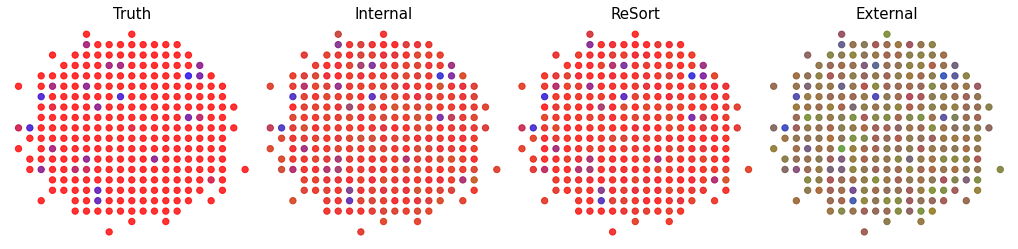

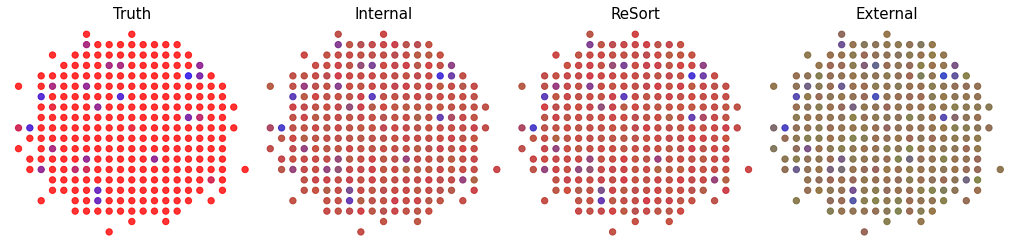

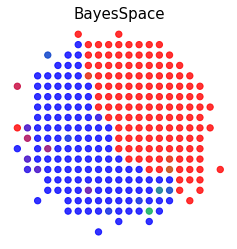

In [15]:
## Visualize patterns detected by MIST
pr_all = []
for method in methods:
    fmt = 'csv'
    if method == 'stereoscope':
        fmt = 'tsv'
        
    f = f"{folder}{method}_results"
    
    xs, ys = [], []
    for ind in truth.index.tolist():
        xs.append(int(ind.split('x')[0]))
        ys.append(int(ind.split('x')[1]))
        
    if method != 'BayesSpace':
        df_mist = read_process_res(f"{f}/estimated_proportions_ref_MIST.{fmt}", method,cell_types)
        df_internal = read_process_res(f"{f}/estimated_proportions_ref_internal.{fmt}", method,cell_types)
        df_external = read_process_res(f"{f}/estimated_proportions_ref_external.{fmt}", method,cell_types)
        df_mist = df_mist.loc[truth.index,:]
        df_internal = df_internal.loc[truth.index,:]
        df_external = df_external.loc[truth.index,:]
        f = plt.figure(figsize= (18, 4))
        s = 40
        ax1 = plt.subplot(1, 4, 1)
        ax1.scatter(xs, ys, c=truth.values, s=s, cmap='Reds', vmin=0, vmax=1, alpha=0.8)
        ax1.set_title('Truth', fontsize=15)
        ax1.axis("off")

        ax2 = plt.subplot(1, 4, 2)
        ax2.scatter(xs, ys, c=df_internal.values, s=s, cmap='Reds', vmin=0, vmax=1, alpha=0.8)
        ax2.set_title('Internal', fontsize=15)
        ax2.axis("off")

        ax3 = plt.subplot(1, 4, 3)
        ax3.scatter(xs, ys, c=df_mist.values,  s=s, cmap='Reds', vmin=0, vmax=1, alpha=0.8)
        ax3.set_title('ReSort', fontsize=15)
        ax3.axis("off")

        ax4 = plt.subplot(1, 4, 4)
        ax4.set_title('External', fontsize=15)
        ax4.scatter(xs, ys, c=df_external.values,  s=s, cmap='Reds', vmin=0, vmax=1, alpha=0.8)
        ax4.axis("off")

        plt.subplots_adjust(wspace=0.01)
        plt.savefig(f"Infiltrated_spatial_celll_pattern_compare_{method}.png", dpi=300, bbox_inches='tight')

        pr_int = customize_precision_recall_fscore(truth, df_internal)
        pr_ext = customize_precision_recall_fscore(truth, df_external)
        pr_mist = customize_precision_recall_fscore(truth, df_mist)

        pr_int['reference'] = 'Internal'
        pr_ext['reference'] = 'External'
        pr_mist['reference'] = 'ReSort'

        pr_refs = pd.concat([pr_int, pr_ext, pr_mist])
        pr_refs['method'] = method
        pr_all.append(pr_refs)
        print(method)
    else:
        df = read_process_res(f"{f}/estimated_proportions_BayesSpace.{fmt}", method, cell_types)
        df = df.loc[truth.index,:]
        f = plt.figure(figsize= (4, 4))
        s = 40
        ax1 = plt.subplot(1, 1, 1)
        ax1.scatter(xs, ys, c=df.values, s=s, cmap='Reds', vmin=0, vmax=1, alpha=0.8)
        ax1.set_title('BayesSpace', fontsize=15)
        ax1.axis("off")
        plt.savefig(f"Infiltrated_spatial_celll_pattern_BayesSpace.png", dpi=300, bbox_inches='tight')
        pr_df = customize_precision_recall_fscore(truth, df)
        pr_df['reference'] = 'BayesSpace'
        pr_df['method'] = 'BayesSpace'
        pr_all.append(pr_df)
        
pr_all = pd.concat(pr_all)
pr_all = pr_all.sort_values("F1 Weighted")
pr_all

In [16]:
pr_all.to_csv("Table1_Precision_Recall_FScore.csv")

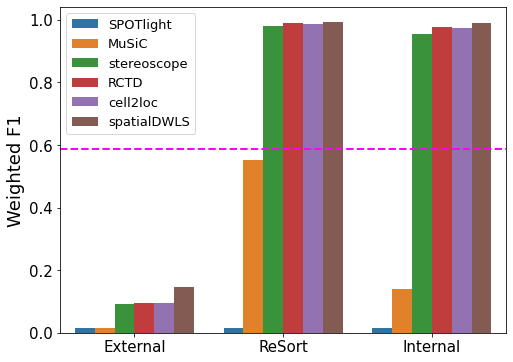

In [17]:
f = plt.figure(figsize=(8, 6))
ax = plt.subplot(1,1,1)
sns.barplot(data=pr_all, x='reference', y='F1 Weighted', hue='method', 
            order=['External', 'ReSort', 'Internal'], 
            hue_order=['spotlight', 'music', 'stereoscope', 'RCTD', 'cell2loc', 'spatialDWLS'], ax=ax)

ax.axhline(y=pr_all.loc[pr_all.method=='BayesSpace', 
                        'F1 Weighted'].values, ls='--',
           color='magenta', lw=2)

ax.tick_params(axis='both', labelsize=15)
h, l = ax.get_legend_handles_labels()
ax.legend(handles = h, labels=['SPOTlight', 'MuSiC', 'stereoscope', 'RCTD', 'cell2loc', 'spatialDWLS'], fontsize=13, ncol=1)
ax.set_xlabel("")
ax.set_ylabel("Weighted F1", fontsize=18)
plt.savefig("Fig2-Infiltrated_weighted_F1_barplot.png", bbox_inches='tight', dpi=100)

In [18]:
pr_all.to_csv("Infiltrated_precision_recall_f1_table.csv")

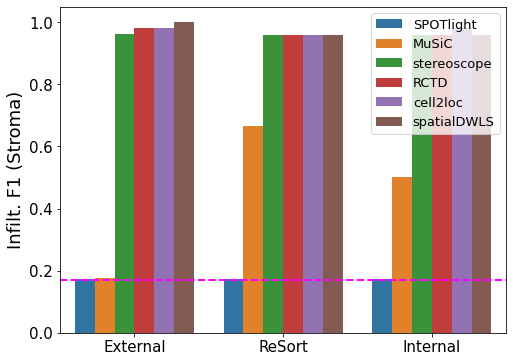

In [19]:
f = plt.figure(figsize=(8, 6))
ax = plt.subplot(1,1,1)
sns.barplot(data=pr_all, x='reference', y='F1 Stroma', hue='method', 
            order=['External', 'ReSort', 'Internal'], 
            hue_order=['spotlight', 'music', 'stereoscope', 'RCTD', 'cell2loc', 'spatialDWLS'], ax=ax)

ax.axhline(y=pr_all.loc[pr_all.method=='BayesSpace', 'F1 Stroma'].values, ls='--', color='magenta', lw=2)

ax.tick_params(axis='both', labelsize=15)
h, l = ax.get_legend_handles_labels()
ax.legend(handles = h, labels=['SPOTlight', 'MuSiC', 'stereoscope', 'RCTD', 'cell2loc', 'spatialDWLS'], fontsize=13, ncol=1)
ax.set_xlabel("")
ax.set_ylabel("Infilt. F1 (Stroma)", fontsize=18)
plt.savefig("Fig2-Stroma_Infiltrated_Tumor_F1_barplot.png", bbox_inches='tight', dpi=100)

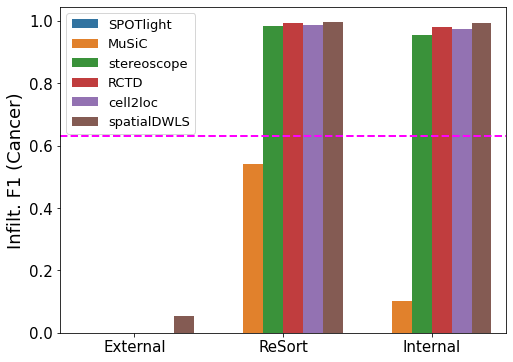

In [20]:
f = plt.figure(figsize=(8, 6))
ax = plt.subplot(1,1,1)
sns.barplot(data=pr_all, x='reference', y='F1 Cancer', hue='method', 
            order=['External', 'ReSort', 'Internal'], 
            hue_order=['spotlight', 'music', 'stereoscope', 'RCTD', 'cell2loc', 'spatialDWLS'], ax=ax)
ax.axhline(y=pr_all.loc[pr_all.method=='BayesSpace', 'F1 Cancer'].values, ls='--', color='magenta', lw=2)

ax.tick_params(axis='both', labelsize=15)
h, l = ax.get_legend_handles_labels()
ax.legend(handles = h, labels=['SPOTlight', 'MuSiC', 'stereoscope', 'RCTD', 'cell2loc', 'spatialDWLS'], fontsize=13, ncol=1)
ax.set_xlabel("")
ax.set_ylabel("Infilt. F1 (Cancer)", fontsize=18)
plt.savefig("Fig2-Cancer_Infiltrated_Tumor_F1_barplot.png", bbox_inches='tight', dpi=100)

In [21]:
pr_all

,Precision Cancer,Recall Cancer,F1 Cancer,Precision Stroma,Recall Stroma,F1 Stroma,F1 Weighted,reference,method
0,0.000000,0.000000,0.000000,0.095588,1.000000,0.174497,0.016680,External,spotlight
0,0.000000,0.000000,0.000000,0.095588,1.000000,0.174497,0.016680,Internal,spotlight
0,0.000000,0.000000,0.000000,0.095588,1.000000,0.174497,0.016680,ReSort,spotlight
0,0.000000,0.000000,0.000000,0.095941,1.000000,0.175084,0.016736,External,music
0,0.000000,0.000000,0.000000,0.961538,0.961538,0.961538,0.091912,External,stereoscope
0,0.000000,0.000000,0.000000,1.000000,0.961538,0.980392,0.093714,External,RCTD
0,0.000000,0.000000,0.000000,1.000000,0.961538,0.980392,0.093714,External,cell2loc
0,1.000000,0.052846,0.100386,0.337838,0.961538,0.500000,0.138584,Internal,music
0,1.000000,0.028455,0.055336,1.000000,1.000000,1.000000,0.145635,External,spatialDWLS
0,1.000000,0.369919,0.540059,0.510204,0.961538,0.666667,0.552162,ReSort,music
